### Code to read IDL sav Blockage files and apply to radar

In [2]:
import os, sys, glob, math, gzip
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import pyart
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import matplotlib.colors as colors
import requests
import shutil
import warnings
warnings.filterwarnings("ignore")
import scipy.io as sio
from scipy.io import readsav
np.set_printoptions(threshold=sys.maxsize) 

# Download input files

response = requests.get('https://pmm-gv.gsfc.nasa.gov/pub/NPOL/temp/VN/V2.0/temp/KBBX_2022_1230_041406.cf.gz')
open("./KBBX_2022_1230_041406.cf.gz", "wb").write(response.content)
file = "./KBBX_2022_1230_041406.cf.gz"

response = requests.get('https://pmm-gv.gsfc.nasa.gov/pub/gpm-validation/data/gpmgv/blockage/KBBX/KBBX.BeamBlockage_00.50.sav')
open("./KBBX.BeamBlockage_00.50.sav", "wb").write(response.content)
sav_fname = "./KBBX.BeamBlockage_00.50.sav"

fileb = os.path.basename(file)[0:-3]
gunzip_shutil(file, fileb)
radar = pyart.io.read(fileb, file_field_names=True)
radar = get_zz(radar)

print(' ','Input Fields:',radar.fields.keys(),sep='\n')

sav_data = readsav(sav_fname)

print('Save file data keys:  ',sav_data.keys(),sep='\n')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

 
Input Fields:
dict_keys(['DZ', 'DR', 'PH', 'RH', 'CF', 'VR', 'SW', 'SD', 'KD', 'CZ', 'ZZ'])
Save file data keys:  
dict_keys(['site', 'elev', 'azimuths', 'ranges_out', 'blockage_out'])


## Find Fully Blocked Azimuths

In [3]:
# Read IDL sav file for FULL (1.0) blocked azimuths.
# Populate block_array

block_array =[]

for az in range(0, 359):
    dis = []
    for rng in range(0, 229):
        x = sav_data['blockage_out'][az][rng]
        if (x == 1):
            rngdiff = rng - (rng-1)
            if rngdiff == 1:
                dis.append(rng)
    if dis:
        block_array.append({'hmin': 0, 'hmax': None, 'rmin': np.min(dis) * 1000, 'rmax': np.max(dis) * 1000,
                            'azmin': az-1, 'azmax': az+1, 'elmin': 0, 'elmax': 0.5})


In [4]:
# Apply FULL Blockages to radar data

radar = set_blockage(radar, block_array)

dz = radar.fields['CZ']['data']

block_flag = np.ma.zeros((radar.nrays, radar.ngates), dtype=int)
block_flag = np.ma.filled(block_flag, fill_value=0.0)

apply_block = np.equal(dz,-888)
block_flag[apply_block] = 1

block_dict = {"data": block_flag, "units": "0: False, 1: True",
              "long_name": "F_BLOCK", "_FillValue": -32767.0,
              "standard_name": "F_BLOCK",}
radar.add_field("F_BLOCK", block_dict, replace_existing=True)

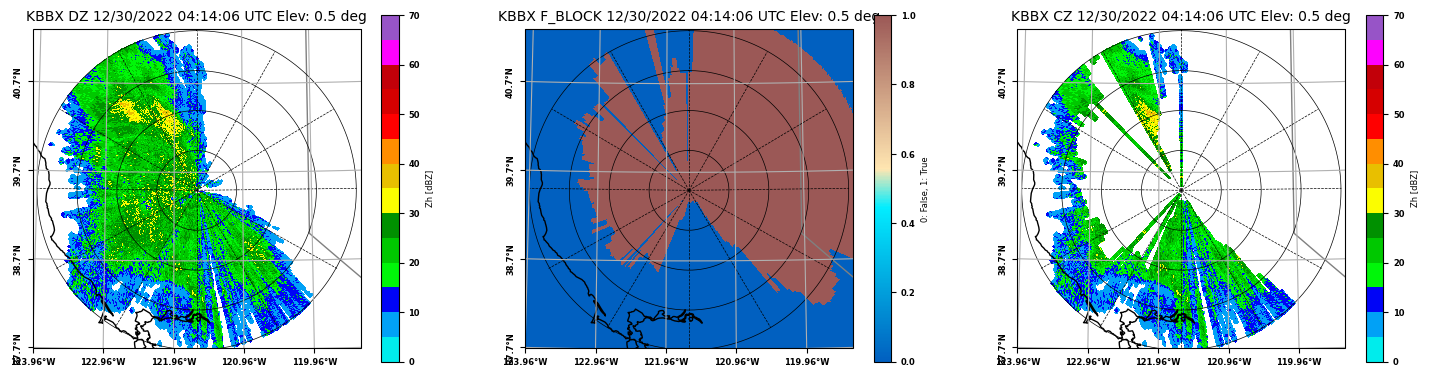

In [5]:
# Plot FULL blockages and apply to CZ

lim = [-200, 200]

three_panel_plot(radar, sweep=0, var1='DZ', vmin1=0, vmax1=70,
               cmap1=discrete_cmap(14,'pyart_NWSRef'), var2='F_BLOCK', vmin2=0, vmax2=1,
               cmap2='pyart_BlueBrown10', var3='CZ', vmin3=0, vmax3=70, 
               cmap3=discrete_cmap(14,'pyart_NWSRef'), units2='0: False, 1: True',
               xlim=lim, ylim=lim, units1='Zh [dBZ]', units3='Zh [dBZ]')

## Find Partially Blocked Azimuths

In [6]:
nf = radar.fields['ZZ']['data']
radar.add_field_like('ZZ','CZ',nf,replace_existing=True)

# Read IDL sav file for PARTIAL ( >0 and <1 ) blocked azimuths.
# Populate block_array

block_array =[]

for az in range(0, 359):
    dis = []
    for rng in range(0, 229):
        x = sav_data['blockage_out'][az][rng]
        if (x > 0 and x < 1):
            rngdiff = rng - (rng-1)
            if rngdiff == 1:
                dis.append(rng)
    if dis:
        block_array.append({'hmin': 0, 'hmax': None, 'rmin': np.min(dis) * 1000, 'rmax': np.max(dis) * 1000,
                            'azmin': az-1, 'azmax': az+1, 'elmin': 0, 'elmax': 0.5})

In [7]:
# Apply PARTIAL Blockages to radar data

radar = set_blockage(radar, block_array)

dz = radar.fields['CZ']['data']

block_flag = np.ma.zeros((radar.nrays, radar.ngates), dtype=int)
block_flag = np.ma.filled(block_flag, fill_value=0.0)

apply_block = np.equal(dz,-888)
block_flag[apply_block] = 1

block_dict = {"data": block_flag, "units": "0: False, 1: True",
              "long_name": "P_BLOCK", "_FillValue": -32767.0,
              "standard_name": "P_BLOCK",}
radar.add_field("P_BLOCK", block_dict, replace_existing=True)

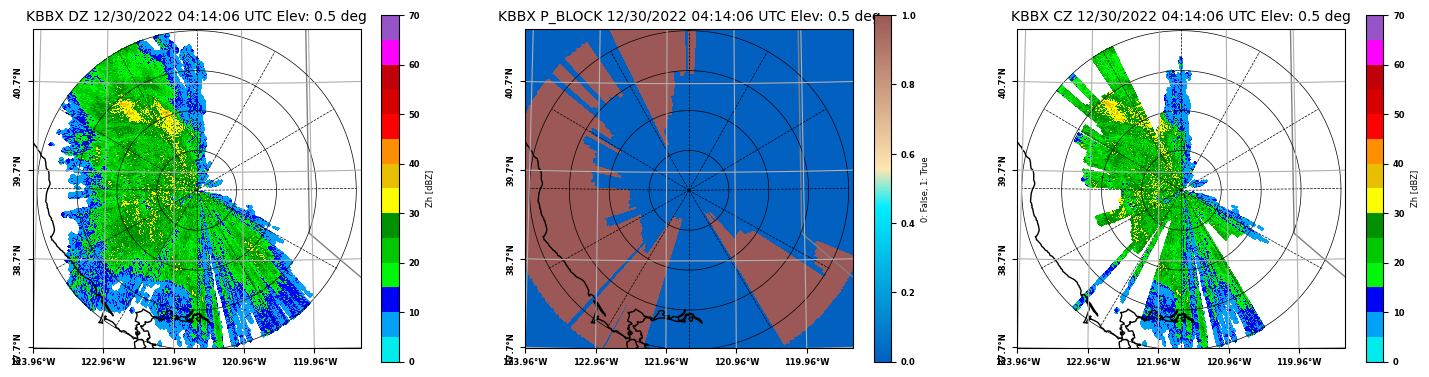

In [8]:
# Plot Partial blockages and apply to CZ

lim = [-200, 200]

three_panel_plot(radar, sweep=0, var1='DZ', vmin1=0, vmax1=70,
               cmap1=discrete_cmap(14,'pyart_NWSRef'), var2='P_BLOCK', vmin2=0, vmax2=1,
               cmap2='pyart_BlueBrown10', var3='CZ', vmin3=0, vmax3=70, 
               cmap3=discrete_cmap(14,'pyart_NWSRef'), units2='0: False, 1: True',
               xlim=lim, ylim=lim, units1='Zh [dBZ]', units3='Zh [dBZ]')

## Find ALL Blocked (FULL and Partial) Azimuths

In [9]:
nf = radar.fields['ZZ']['data']
radar.add_field_like('ZZ','CZ',nf,replace_existing=True)

# Read IDL sav file for ALL ( > 0 and <= 1 ) blocked azimuths.
# Populate block_array

block_array =[]

for az in range(0, 359):
    dis = []
    for rng in range(0, 229):
        x = sav_data['blockage_out'][az][rng]
        if (x > 0):
            rngdiff = rng - (rng-1)
            if rngdiff == 1:
                dis.append(rng)
    if dis:
        block_array.append({'hmin': 0, 'hmax': None, 'rmin': np.min(dis) * 1000, 'rmax': np.max(dis) * 1000,
                            'azmin': az-1, 'azmax': az+1, 'elmin': 0, 'elmax': 0.5})

In [10]:
# Apply ALL Blockages to radar data

radar = set_blockage(radar, block_array)

dz = radar.fields['CZ']['data']

block_flag = np.ma.zeros((radar.nrays, radar.ngates), dtype=int)
block_flag = np.ma.filled(block_flag, fill_value=0.0)

apply_block = np.equal(dz,-888)
block_flag[apply_block] = 1

block_dict = {"data": block_flag, "units": "0: False, 1: True",
              "long_name": "A_BLOCK", "_FillValue": -32767.0,
              "standard_name": "A_BLOCK",}
radar.add_field("A_BLOCK", block_dict, replace_existing=True)

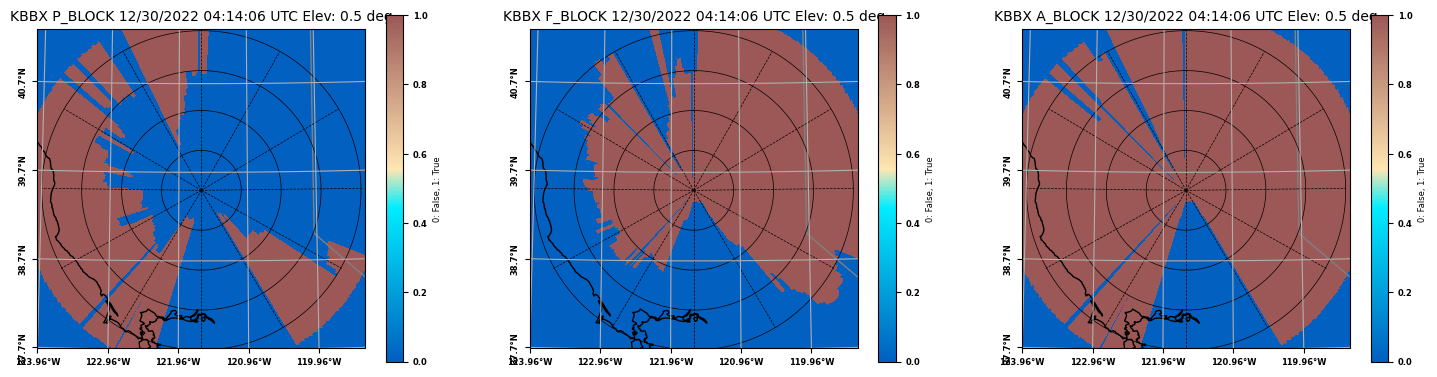

In [11]:
# Plot ALL 3 blockage fields

lim = [-200, 200]

three_panel_plot(radar, sweep=0, var1='P_BLOCK', vmin1=0, vmax1=1,
               cmap1='pyart_BlueBrown10', var2='F_BLOCK', vmin2=0, vmax2=1,
               cmap2='pyart_BlueBrown10', var3='A_BLOCK', vmin3=0, vmax3=1, 
               cmap3='pyart_BlueBrown10', units2='0: False, 1: True',
               xlim=lim, ylim=lim, units1='0: False, 1: True', units3='0: False, 1: True')

## Start Here

In [1]:
def set_blockage(radar, sector_dict):

    """
    Set known blocages to -888
    """

    for k in range(len(sector_dict)):
        
        sector = sector_dict[k]
        
        block_flag = np.ma.ones((radar.nrays, radar.ngates), dtype=int)
    
        # check for altitude limits
        if sector['hmin'] is not None:
            block_flag[radar.gate_altitude['data'] < sector['hmin']] = 0
        if sector['hmax'] is not None:
            block_flag[radar.gate_altitude['data'] > sector['hmax']] = 0

        # check for range limits
        if sector['rmin'] is not None:
            block_flag[:, radar.range['data'] < sector['rmin']] = 0
        if sector['rmax'] is not None:
            block_flag[:, radar.range['data'] > sector['rmax']] = 0

        # check elevation angle limits
        if sector['elmin'] is not None:
            block_flag[radar.elevation['data'] <= sector['elmin'], :] = 0
        if sector['elmax'] is not None:
            block_flag[radar.elevation['data'] >= sector['elmax'], :] = 0

        # check min and max azimuth angle
        if sector['azmin'] is not None and sector['azmax'] is not None:
            block_flag[radar.azimuth['data'] < sector['azmin'], :] = 0
            block_flag[radar.azimuth['data'] > sector['azmax'], :] = 0
    
    #block_field = block_flag
        apply_block = np.equal(block_flag,1)
    
    #fields = ['CZ','DR','KD','PH','RH','SD','SW','VR','FS','FW','RC','RP','MW','MI','DM','NW']
        fields =['CZ']
        for fld in fields:
            nf = radar.fields[fld]['data']
            nf[apply_block] = -888
            radar.add_field_like(fld,fld,nf,replace_existing=True)
    
    return radar

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

def extract_unmasked_data(radar, field, bad=-32767.0):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def add_field_to_radar_object(field, radar, field_name='UN', units='',
                              long_name='UNKNOWN', standard_name='UNKNOWN',
                              dz_field='CZ'):
    
    fill_value = -32767.0
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value,
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask',
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def two_panel_plot(radar, sweep=0, var1='reflectivity', title1 = ' ', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity', title2 = ' ',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    
    site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep = get_radar_info(radar, sweep)
    title1 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var1,mydate,mytime,elv)
    title2 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var2,mydate,mytime,elv)
    
    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = xlim[1] * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

    min_lat = radar_lat - maxrange_meters * meters_to_lat
    max_lat = radar_lat + maxrange_meters * meters_to_lat
    min_lon = radar_lon - maxrange_meters * meters_to_lon
    max_lon = radar_lon + maxrange_meters * meters_to_lon
    min_lon_rn=round(min_lon,2)
    max_lon_rn=round(max_lon,2)
    min_lat_rn=round(min_lat,2)
    max_lat_rn=round(max_lat,2)
    lon_grid = np.arange(min_lon_rn - 1.00 , max_lon_rn + 1.00, 1.0)
    lat_grid = np.arange(min_lat_rn - 1.00 , max_lat_rn + 1.00, 1.0)
    
    SMALL_SIZE = 6
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE, weight='bold') # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    projection = ccrs.LambertConformal(radar_lon, radar_lat)
    display = pyart.graph.RadarMapDisplay(radar)
    fig = plt.figure(figsize=(12,4.5))
    
    ax1 = fig.add_subplot(121,projection=projection)
    display.plot_ppi_map(var1, sweep, vmin=vmin1, vmax=vmax1,
                     resolution='10m',
                     title = title1,
                     projection=projection, ax=ax1,
                     cmap=cmap1,
                     colorbar_label=units1,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax2 = fig.add_subplot(122,projection=projection)
    display.plot_ppi_map(var2, sweep, vmin=vmin2, vmax=vmax2,
                     resolution='10m',
                     title = title2,
                     projection=projection, ax=ax2,
                     cmap=cmap2,
                     colorbar_label=units2,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    if return_flag:
        return fig, ax1, ax2, display

def add_radials(radar,display,max_range):

    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = max_range * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))
    
    for azi in range(0,360,30):
        azimuth = 90. - azi
        dazimuth = azimuth * dtor
        lon_maxrange = radar_lon + math.cos(dazimuth) * meters_to_lon * maxrange_meters
        lat_maxrange = radar_lat + math.sin(dazimuth) * meters_to_lat * maxrange_meters
        display.plot_line_geo([radar_lon, lon_maxrange], [radar_lat, lat_maxrange],
                              line_style='k--',lw=0.5)

def get_radar_info(radar, sweep):
    #
    # *** get radar elevation, date, time
    #
    radar_DT = pyart.util.datetime_from_radar(radar)
    elv=radar.fixed_angle['data'][sweep]
    string_csweep = str(sweep).zfill(2)
    month = str(radar_DT.month).zfill(2)
    day = str(radar_DT.day).zfill(2)
    year = str(radar_DT.year).zfill(4)
    hh = str(radar_DT.hour).zfill(2)
    mm = str(radar_DT.minute).zfill(2)
    ss = str(radar_DT.second).zfill(2)
    mydate = month + '/' + day + '/' + year
    mytime = hh + ':' + mm + ':' + ss
    if 'site_name' in radar.metadata.keys():
        site = radar.metadata['site_name'].upper()
    elif 'instrument_name' in radar.metadata.keys():
        if isinstance(radar.metadata['instrument_name'], bytes):
            site = radar.metadata['instrument_name'].decode().upper()
        else:
            site = radar.metadata['instrument_name'].upper()
    else:
        site=''

    return site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep    
    
def adjust_fhc_colorbar_for_pyart(cb,type='summer'):
    if type == 'summer':
        cb.set_ticks(np.arange(1.4, 10, 0.9))
        cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                               'Wet Snow', 'Vertical Ice', 'LD Graupel',
                               'HD Graupel', 'Hail', 'Big Drops'])
    if type == 'winter':
        cb.set_ticks(np.arange(1.4, 7, 0.9))
        cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'LightRain', 'Rain'])

    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)

    return cb

def three_panel_plot(radar, sweep=0, var1='reflectivity', title1 = ' ', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity', title2 = ' ',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150], var3='reflectivity', title3 = ' ', vmin3=0, vmax3=65,
                   cmap3='RdYlBu_r', units3='dBZ', ):
    
    site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep = get_radar_info(radar, sweep)
    title1 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var1,mydate,mytime,elv)
    title2 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var2,mydate,mytime,elv)
    title3 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var3,mydate,mytime,elv)
    
    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = xlim[1] * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

    min_lat = radar_lat - maxrange_meters * meters_to_lat
    max_lat = radar_lat + maxrange_meters * meters_to_lat
    min_lon = radar_lon - maxrange_meters * meters_to_lon
    max_lon = radar_lon + maxrange_meters * meters_to_lon
    min_lon_rn=round(min_lon,2)
    max_lon_rn=round(max_lon,2)
    min_lat_rn=round(min_lat,2)
    max_lat_rn=round(max_lat,2)
    lon_grid = np.arange(min_lon_rn - 1.00 , max_lon_rn + 1.00, 1.0)
    lat_grid = np.arange(min_lat_rn - 1.00 , max_lat_rn + 1.00, 1.0)
    
    SMALL_SIZE = 6
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE, weight='bold') # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    projection = ccrs.LambertConformal(radar_lon, radar_lat)
    display = pyart.graph.RadarMapDisplay(radar)
    fig = plt.figure(figsize=(18,4.5))
    
    ax1 = fig.add_subplot(131,projection=projection)
    display.plot_ppi_map(var1, sweep, vmin=vmin1, vmax=vmax1,
                     resolution='10m',
                     title = title1,
                     projection=projection, ax=ax1,
                     cmap=cmap1,
                     colorbar_label=units1,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax2 = fig.add_subplot(132,projection=projection)
    display.plot_ppi_map(var2, sweep, vmin=vmin2, vmax=vmax2,
                     resolution='10m',
                     title = title2,
                     projection=projection, ax=ax2,
                     cmap=cmap2,
                     colorbar_label=units2,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax3 = fig.add_subplot(133,projection=projection)
    display.plot_ppi_map(var3, sweep, vmin=vmin3, vmax=vmax3,
                     resolution='10m',
                     title = title3,
                     projection=projection, ax=ax3,
                     cmap=cmap3,
                     colorbar_label=units3,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    if return_flag:
        return fig, ax1, ax2, ax3, display
    
def gunzip_shutil(source_filepath, dest_filepath, block_size=65536):
    with gzip.open(source_filepath, 'rb') as s_file, open(dest_filepath, 'wb') as d_file:
        shutil.copyfileobj(s_file, d_file, block_size)
        
def get_zz(radar):
    
    zz = radar.fields['CZ']['data'].copy()
    add_field_to_radar_object(zz, radar, field_name='ZZ', 
                          units=' ',
                          long_name='Corrected Reflectivity', 
                          standard_name='Corrected Reflectivity', 
                          dz_field='DZ')
    return radar